In [1]:
#neccesary packages
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read data into data_set
data_set = np.genfromtxt("hw04_data_set.csv", delimiter = ",")
# get X and Y values
X= data_set[:,0]
Y = data_set[:,1]

In [3]:
#Split into train and test sets
train_indices = np.arange(1,151)
test_indices = np.arange(151,273)
X_train =X[train_indices]
y_train = Y[train_indices]
X_test = X[test_indices]
y_test = Y[test_indices]

In [4]:
#store the number of points
N_train = X_train.shape[0]
N_test = X_test.shape[0]

In [5]:
#parameters
bin_width = 0.37
origin = 1.5


## Regressogram

In [6]:
def RMSE(y_predicted,y_test):
    sum_squares = np.sum((y_test - y_predicted) **2)
    avg_sum_squares = sum_squares / y_test.shape
    return np.sqrt(avg_sum_squares)[0]
    
def plot_regressogram(regressogram, left_boundries, right_boundries,no_bin):
#a function that will calculate regressogram, and plot necceserray fields          
    #plot train and test sets
    plt.figure(figsize = (10, 6))
    plt.xlabel("Eruption time (min)")
    plt.ylabel("Waiting time to next eruption (min)")
    
    plt.plot(X_train, y_train, "b.", markersize = 10, label = "Training Set")
    plt.plot(X_test, y_test, "r.", markersize = 10, label = "Test Set")
    plt.legend(loc = "upper left")
    for n in range(no_bin):
        plt.plot([left_boundries[n], right_boundries[n]], [regressogram[n], regressogram[n]], "k-")
    for n in range(no_bin - 1):
        plt.plot([right_boundries[n], right_boundries[n]], [regressogram[n], regressogram[n + 1]], "k-")   

def regressogram_predict(left_boundries, right_boundries, no_bins, X_test, regressogram):
    y_predicted = np.zeros(X_test.shape[0])
    for n in range(no_bins):
        #predict test points within the boundries with corresponding regressogram value 
        y_predicted[(left_boundries[n]<X_test) & (X_test<= right_boundries[n])] = regressogram[n]
    return y_predicted    
        
def regressogram_calculate(X, y, bin_width, origin):
    min_X = min(X)
    max_X = max(X)
    left_boundries, right_boundries, no_bin = bin_calculate(max_X, bin_width,origin)
    regressogram = np.zeros(no_bin)
    for n in range(no_bin):
        #using formula 8.24 on 8.8
        regressogram[n] = np.array(np.sum([y[i] *(1 if (left_boundries[n]<X[i] and X[i]<= right_boundries[n]) else 0) for i in range (X.shape[0])])
                                  /np.sum([(1 if (left_boundries[n]<X[i] and X[i]<= right_boundries[n]) else 0) for i in range (X.shape[0])]))
    return regressogram, left_boundries, right_boundries,no_bin

def bin_calculate(max_val,width,origin):
#takes the interval, width and starting point, then starting from origin
#generates bins within the interval with given width
    left =  np.arange(origin, max_val, 0.37) 
    right = left + width
    no_bins = left.size
    return left, right, no_bins
    
    
    

Regressogram => RMSE is  5.962617204275405  when h is  0.37


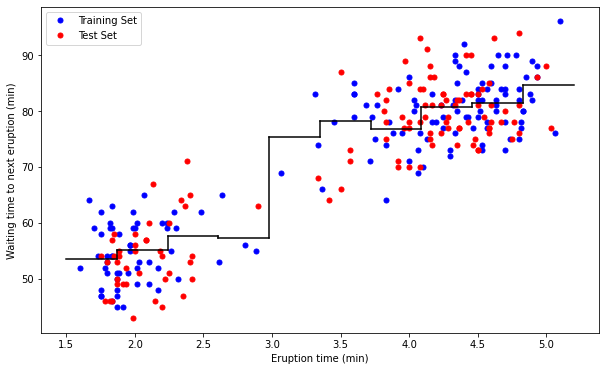

In [7]:
regressogram, left_boundries, right_boundries,no_bin = regressogram_calculate(X_train, y_train, bin_width, origin)
y_predicted_reg = regressogram_predict(left_boundries, right_boundries, no_bin, X_test, regressogram)
rmse_regressogram = RMSE(y_test, y_predicted_reg)
plot_regressogram(regressogram, left_boundries, right_boundries,no_bin)

print("Regressogram => RMSE is ", rmse_regressogram, " when h is ", bin_width)




## Running Mean Smoother

In [8]:
def plot_running_mean_smoother(vals, running_mean_smoother):
#a function that will calculate regressogram, and plot necceserray fields          
    #plot train and test sets
    plt.figure(figsize = (10, 6))
    plt.xlabel("Eruption time (min)")
    plt.ylabel("Waiting time to next eruption (min)")
    
    plt.plot(X_train, y_train, "b.", markersize = 10, label = "Training Set")
    plt.plot(X_test, y_test, "r.", markersize = 10, label = "Test Set")
    plt.legend(loc = "upper left")
    
    plt.plot(vals, running_mean_smoother, color = "black")
    
def running_mean_smoother_predict(X_train, X_test, y_train, bin_width):
    return running_mean_smoother_calculate(X_train,X_test, y_train, bin_width)

def running_mean_smoother_calculate(X_train,vals, y_train, bin_width):
    N = vals.shape[0]
    running_mean_smoother = np.zeros(N)
    for n in range(N):
        #8.25
        running_mean_smoother[n] = np.array(np.sum([y_train[i] *(1 if ((vals[n]-(0.5)*bin_width)<X_train[i] and X_train[i]<= (vals[n]+(0.5)*bin_width)) else 0) for i in range (X_train.shape[0])]))
        dev = np.sum([(1 if ((vals[n]-((0.5)*bin_width))<X_train[i] and X_train[i]<= (vals[n]+(0.5)*bin_width)) else 0) for i in range (X_train.shape[0])])
        if (dev != 0):
            running_mean_smoother[n] /= dev
        else:
            running_mean_smoother[n] = 0
    return running_mean_smoother



Running Mean Smoother => RMSE is  6.089003211720321  when h is  0.37


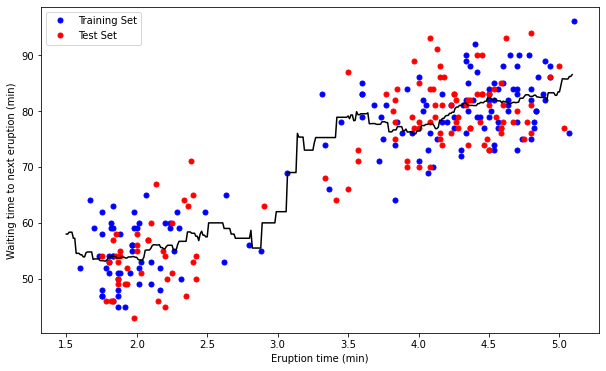

In [9]:
y_predicted_run = running_mean_smoother_predict(X_train,X_test, y_train, bin_width)
rmse_running_mean_smoother = RMSE(y_test, y_predicted_run)
vals = np.arange(origin, max(X_train), 0.01)
running_mean_smoother = running_mean_smoother_calculate(X_train,vals, y_train, bin_width)
plot_running_mean_smoother(vals, running_mean_smoother)
print("Running Mean Smoother => RMSE is ", rmse_running_mean_smoother, " when h is ", bin_width)

## Kernel Smoother

In [10]:
def plot_kernel_smoother(vals, kernel_smoother):
#a function that will calculate regressogram, and plot necceserray fields          
    #plot train and test sets
    plt.figure(figsize = (10, 6))
    plt.xlabel("Eruption time (min)")
    plt.ylabel("Waiting time to next eruption (min)")
    
    plt.plot(X_train, y_train, "b.", markersize = 10, label = "Training Set")
    plt.plot(X_test, y_test, "r.", markersize = 10, label = "Test Set")
    plt.legend(loc = "upper left")
    
    plt.plot(vals, kernel_smoother, color = "black")
    
def kernel_smoother_predict(X_train, X_test, y_train, bin_width):
    return kernel_smoother_calculate(X_train,X_test, y_train, bin_width)

def kernel_smoother_calculate(X_train,vals, y_train, bin_width):
    N = vals.shape[0]
    kernel_smoother = np.zeros(N)
    for n in range(N):
        #based on formula 8.26 on chapter 8.8
        kernel_smoother[n] = np.array(np.sum([y_train[i]*(1 / (np.sqrt(2 * np.pi))) * np.exp(-(vals[n] - X_train[i])**2 / (2 * (bin_width**2))) for i in range(X_train.shape[0])]))
        dev = np.sum([(1 / (np.sqrt(2 * np.pi))) * np.exp(-(vals[n] - X_train[i])**2 / (2 * (bin_width**2))) for i in range(X_train.shape[0])])

        if (dev != 0):
            kernel_smoother[n] /= dev
        else:
            running_mean_smoother[n] = 0
    return kernel_smoother




Kernel Smoother => RMSE is  5.874362846844968  when h is  0.37


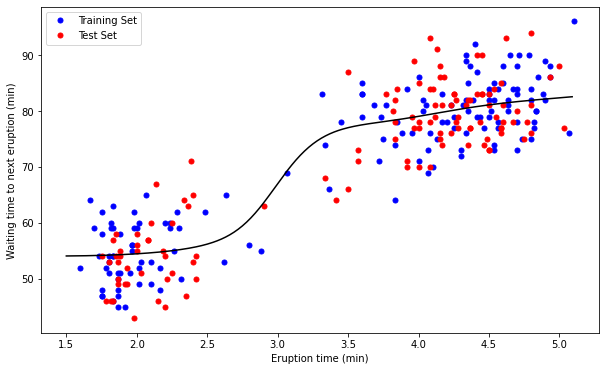

In [11]:
y_predicted_ker = kernel_smoother_predict(X_train,X_test, y_train, bin_width)
rmse_kernel_smoother = RMSE(y_test, y_predicted_ker)
vals = np.arange(origin, max(X_train), 0.01)
kernel_smoother = kernel_smoother_calculate(X_train,vals, y_train, bin_width)
plot_kernel_smoother(vals, kernel_smoother)
print("Kernel Smoother => RMSE is ", rmse_kernel_smoother, " when h is ", bin_width)